In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

# Import .././ directory
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from synapgrad.utils.data import split_dataset, DataLoader, DataLoaderCallback
from synapgrad.utils.train import Trainer, Evaluator

In [3]:
supported_engines = ['synapgrad', 'torch']

In [4]:
seed = 1337
engine_str = 'synapgrad'

In [5]:
epochs = 20
batch_size = 64
lr = 0.01

In [6]:
if engine_str == 'synapgrad':
    import synapgrad as engine
    from synapgrad import nn
    from synapgrad import optim
elif engine_str == 'torch':
    import torch as engine
    from torch import nn
    from torch import optim
engine.manual_seed(seed)
print("Engine:", engine_str)

Engine: synapgrad


Load dataset

In [7]:
(trainX, trainy), (testX, testy) = mnist.load_data()
(trainX, trainy), (valX, valy), _  = split_dataset(trainX, trainy, test_split=0.2)

trainX = trainX / 255.0
valX = valX / 255.0
testX = testX / 255.0

assert 0 <= np.max(trainX) <= 1

# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Val: X=%s, y=%s' % (valX.shape, valy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

Train: X=(48000, 28, 28), y=(48000,)
Val: X=(12000, 28, 28), y=(12000,)
Test: X=(10000, 28, 28), y=(10000,)


In [8]:
class Transform(DataLoaderCallback):
    
    def __call__(self, data_loader:'DataLoader', X_batch:np.ndarray, y_batch:np.ndarray):
        if engine_str == 'torch':
            x = engine.tensor(X_batch).type(engine.FloatTensor)
            y = engine.tensor(y_batch).type(engine.LongTensor)
        elif engine_str == 'synapgrad':
            x = engine.tensor(X_batch)
            y = engine.tensor(y_batch, dtype=np.int8)
        return x, y

transform_cb = Transform()

train_loader = DataLoader(trainX, trainy, batch_size, engine=engine, transform=transform_cb)
val_loader = DataLoader(valX, valy, batch_size=256, engine=engine, transform=transform_cb) # big batch size for val samples
test_loader = DataLoader(testX, testy, batch_size=256, engine=engine, transform=transform_cb) # big batch size for val samples

print("Train batches:", len(train_loader), "| Val batches:", len(val_loader), "| Test batches:", len(test_loader))

Train batches: 750 | Val batches: 46 | Test batches: 39


Plot a few training images

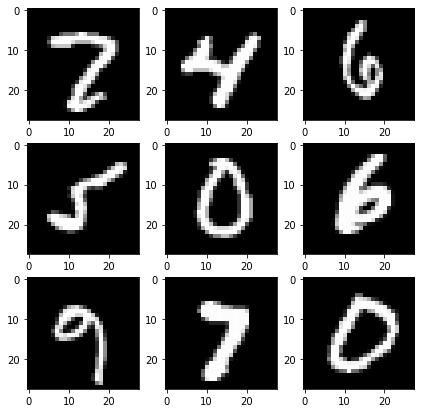

In [9]:
plt.figure(figsize=(7,7))
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
plt.show()

In [10]:
class MultiLayerPerceptron(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten(start_dim=1, end_dim=-1)
        self.linear1 = nn.Linear(784, 200)
        self.linear2 = nn.Linear(200, 100)
        self.logits = nn.Linear(100, 10)
        self.relu = nn.ReLU()
        
        self.mlp = nn.Sequential(
            self.flatten,
            self.linear1,
            self.relu,
            self.linear2,
            self.relu,
            self.logits
        )
        if engine_str == 'synapgrad': self.track_module(self.mlp)
        
    def forward(self, x:engine.Tensor):
        out = self.mlp(x)
        
        return out

model = MultiLayerPerceptron()
print("MLP Model:", model)

MLP Model: MultiLayerPerceptron(tracked_modules=1, parameters=178110, trainable=178110, non_trainable=0)


In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

trainer = Trainer(model, engine)
evaluator = Evaluator(accuracy=True, mode=Evaluator.MULTI_CLASS)
trainer.compile(loss_fn, optimizer, evaluator)
history = trainer.fit(train_loader, epochs=epochs, validation_loader=val_loader)

Epoch: 1/20
750/750 [================================] - 2s 3ms/step - loss: 0.8579 - accuracy: 0.7811 - val_loss: 0.4162 - val_accuracy: 0.8881
Epoch: 2/20
750/750 [================================] - 2s 3ms/step - loss: 0.3702 - accuracy: 0.8969 - val_loss: 0.3237 - val_accuracy: 0.9090
Epoch: 3/20
750/750 [================================] - 2s 3ms/step - loss: 0.3092 - accuracy: 0.9122 - val_loss: 0.2855 - val_accuracy: 0.9191
Epoch: 4/20
750/750 [================================] - 2s 3ms/step - loss: 0.2758 - accuracy: 0.9217 - val_loss: 0.2607 - val_accuracy: 0.9244
Epoch: 5/20
750/750 [================================] - 2s 3ms/step - loss: 0.2517 - accuracy: 0.9284 - val_loss: 0.2420 - val_accuracy: 0.9306
Epoch: 6/20
750/750 [================================] - 2s 3ms/step - loss: 0.2323 - accuracy: 0.9342 - val_loss: 0.2269 - val_accuracy: 0.9350
Epoch: 7/20
750/750 [================================] - 2s 3ms/step - loss: 0.2159 - accuracy: 0.9394 - val_loss: 0.2141 - val_ac

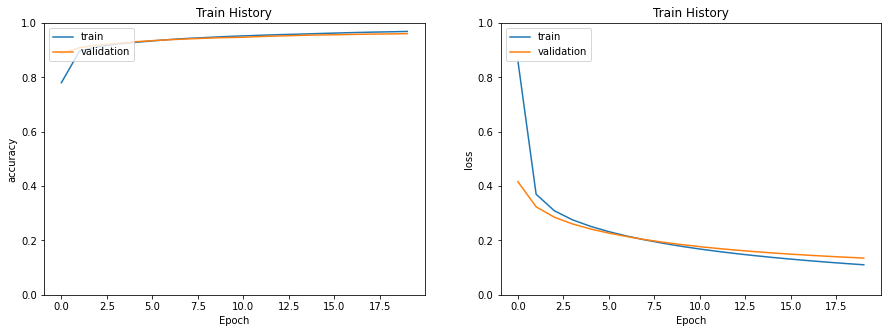

In [12]:
trainer.plot(['accuracy', 'loss'], ylim=[0, 1])

In [13]:
y_pred, y_true = trainer.test(test_loader)
evaluator.report(y_pred, y_true)

[INFO] Testing network...
Accuracy: 0.9631410256410257
[[ 966    0    1    1    0    5    2    3    1    0]
 [   0 1117    2    1    0    1    4    0    8    0]
 [   7    1  995    6    3    1    1    9    6    1]
 [   1    0    4  966    0   16    1    9    7    4]
 [   1    0    6    1  942    1    3    1    2   23]
 [   6    1    0    8    1  859    7    0    4    4]
 [   8    3    0    0    7   15  920    0    3    0]
 [   2    8   16    5    1    1    0  974    3   17]
 [   6    1    2   10    4   12    8    6  920    4]
 [   5    6    1    6   17    4    1    8    3  957]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       979
           1       0.98      0.99      0.98      1133
           2       0.97      0.97      0.97      1030
           3       0.96      0.96      0.96      1008
           4       0.97      0.96      0.96       980
           5       0.94      0.97      0.95       890
           6       0.97      0.96  

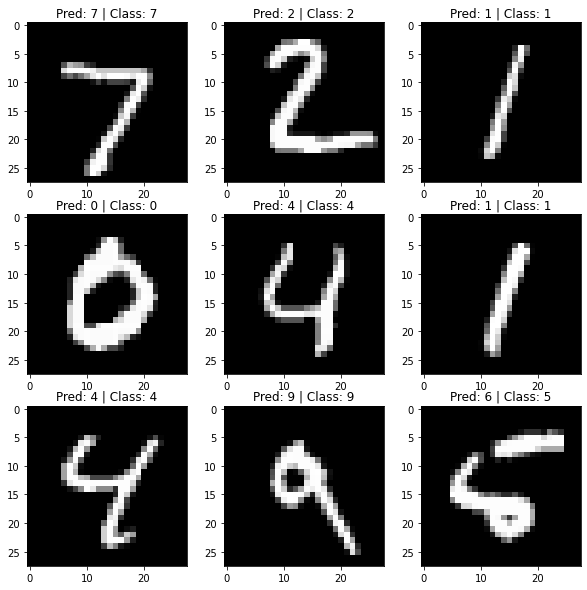

In [14]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(testX[i].reshape(28,28), cmap=plt.get_cmap('gray'))
    pred = y_pred[i].argmax(); label = y_true[i]
    plt.title(f"Pred: {pred} | Class: {label}")
plt.show()